# Imports

In [1]:
import numpy as np
from datetime import datetime
import os

import tclab
import time
import threading

import tkinter as tk
from tkinter import W
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Parameters

In [2]:
Ts = 1

ExpVariable = "MV"

MV0 = 50
DV0 = 50
Delta = 20

# Functions

In [3]:
# --------------------------------
# Define a function to update data
def update_data():
    global t, MV, PV, DV, T2, lab, MVValue, DVValue

    # Get the data
    while not stop_event.is_set():

        if t[-1] == 0:
            last_time = time.time()
            
        t.append(t[-1] + Ts)
        
        try:
            T1Value = float(lab.T1)
            if abs((T1Value - PV[-1])/PV[-1]) > 0.5:
                T1Value = PV[-1]
        except:
            T1Value = PV[-1]
        try:
            T2Value = float(lab.T2)
            if abs((T2Value - T2[-1])/T2[-1]) > 0.5:
                T2Value = T2[-1]            
        except:
            T2Value = T2[-1]       
   
        MV.append(MVValue)
        DV.append(DVValue)
        PV.append(T1Value)
        T2.append(T2Value)
    
        label_temp1.config(text=f'Temperature 1: {T1Value:.2f} °C')
        label_temp2.config(text=f'Temperature 2: {T2Value:.2f} °C')
        
        now = time.time()
        delta = now - last_time
        # print(f"Time delta: {delta:.3f} s")
    
        time.sleep(np.max([0, Ts - delta]))
        last_time = time.time()

# ------------------------------------
# Define a function to update the plot
def update_plot():
    global t, MV, PV, DV, T2
    
    # Update the plot
    l1.set_xdata(range(len(MV)))
    l1.set_ydata(MV)
    ax1.relim()
    ax1.autoscale_view()

    l2.set_xdata(range(len(PV)))
    l2.set_ydata(PV)
    ax2.relim()
    ax2.autoscale_view()
    
    l3.set_xdata(range(len(DV)))
    l3.set_ydata(DV)
    ax3.relim()
    ax3.autoscale_view()
    
    l4.set_xdata(range(len(T2)))
    l4.set_ydata(T2)
    ax4.relim()
    ax4.autoscale_view()    
    
    # Draw the plot
    canvas.draw()   
   
    # Schedule the next update
    root.after(1000*Ts, update_plot)
    
# ------------------------------    
# Define a function to update Q1
def update_Q1(q):
    global lab, root, entry_Q1, MVValue
    
    try:
        qfloat  = float(q)
        lab.Q1(qfloat)
        MVValue = qfloat
    except:
        entry_Q1.delete(0,'end')
        entry_Q1.insert(-1, str(int(MVValue)))
        print('Problem updating MV = Q1')
    
    root.focus()    

# ------------------------------
# Define a function to update Q2
def update_Q2(q):
    global lab, root, entry_Q2, DVValue
    
    try:
        qfloat  = float(q)
        lab.Q2(qfloat)
        DVValue = qfloat
    except:
        entry_Q2.delete(0,'end')
        entry_Q2.insert(-1, str(int(DVValue)))
        print('Problem updating DV = Q2')
    
    root.focus()
        
# -----------------------------------
# Create a function to reset the plot
def reset_update():
    global t, MV, DV, PV, T2, lab

    PVOld = PV[-1]
    T2Old = T2[-1]
    
    # Create lists to store data for the plot
    t = []
    MV = []
    DV = []
    PV = []
    T2 = []    

    t.append(0)
    try:
        T1Value = float(lab.T1)
        if abs((T1Value - PVOld)/PVOld) > 0.5:
            T1Value = PVOld        
    except:
        T1Value = PV[-1]
    try:
        T2Value = float(lab.T2)
        if abs((T2Value - T2Old)/T2Old) > 0.5:
            T2Value = T2Old        
    except:
        T2Value = T2[-1]    
    MV.append(MVValue)
    DV.append(DVValue)
    PV.append(T1Value)
    T2.append(T2Value)

# -------------------------------------------
# Create a function to stop and save the data
def stop_update():
    global t, MV, DV, PV, lab, ExpVariable, fig
    
    # Save data    
    now = datetime.now()
    date_time = now.strftime("%Y-%m-%d-%Hh%M")
    
    # Conversion to array
    t = np.array(t) 
    MV = np.array(MV)
    PV = np.array(PV)
    DV = np.array(DV)     
    
    my_data = np.vstack((t.T,MV.T,PV.T,DV.T))
    my_data = my_data.T
    
    nameFile = 'Open_loop_experiment_on_' + ExpVariable + '_' + date_time
    
    if not os.path.exists('Data'):
        os.makedirs('Data')
    np.savetxt('Data/' + nameFile + '.txt',my_data,delimiter=',',header='t,MV,PV,DV',comments='')
    
    if not os.path.exists('Plots'):
        os.makedirs('Plots')
    fig.savefig('Plots/' + nameFile + '.png',transparent=True)
    fig.savefig('Plots/' + nameFile + '.pdf',transparent=True)     
    
    # Close the tclab connection
    try:
        lab.close()
        stop_event.set()
    except:
        print('TClab already disconnected')
        
    root.destroy()
    
# -----------------------------------    
# Create a function to reset the plot
def exp_update():
    global ExpVariable, exp_button

    if ExpVariable == 'MV':
        ExpVariable = 'DV'
        exp_button.config(text = 'DV Experiment')
    else:
        ExpVariable = 'MV'
        exp_button.config(text = 'MV Experiment')

# Prepare figure

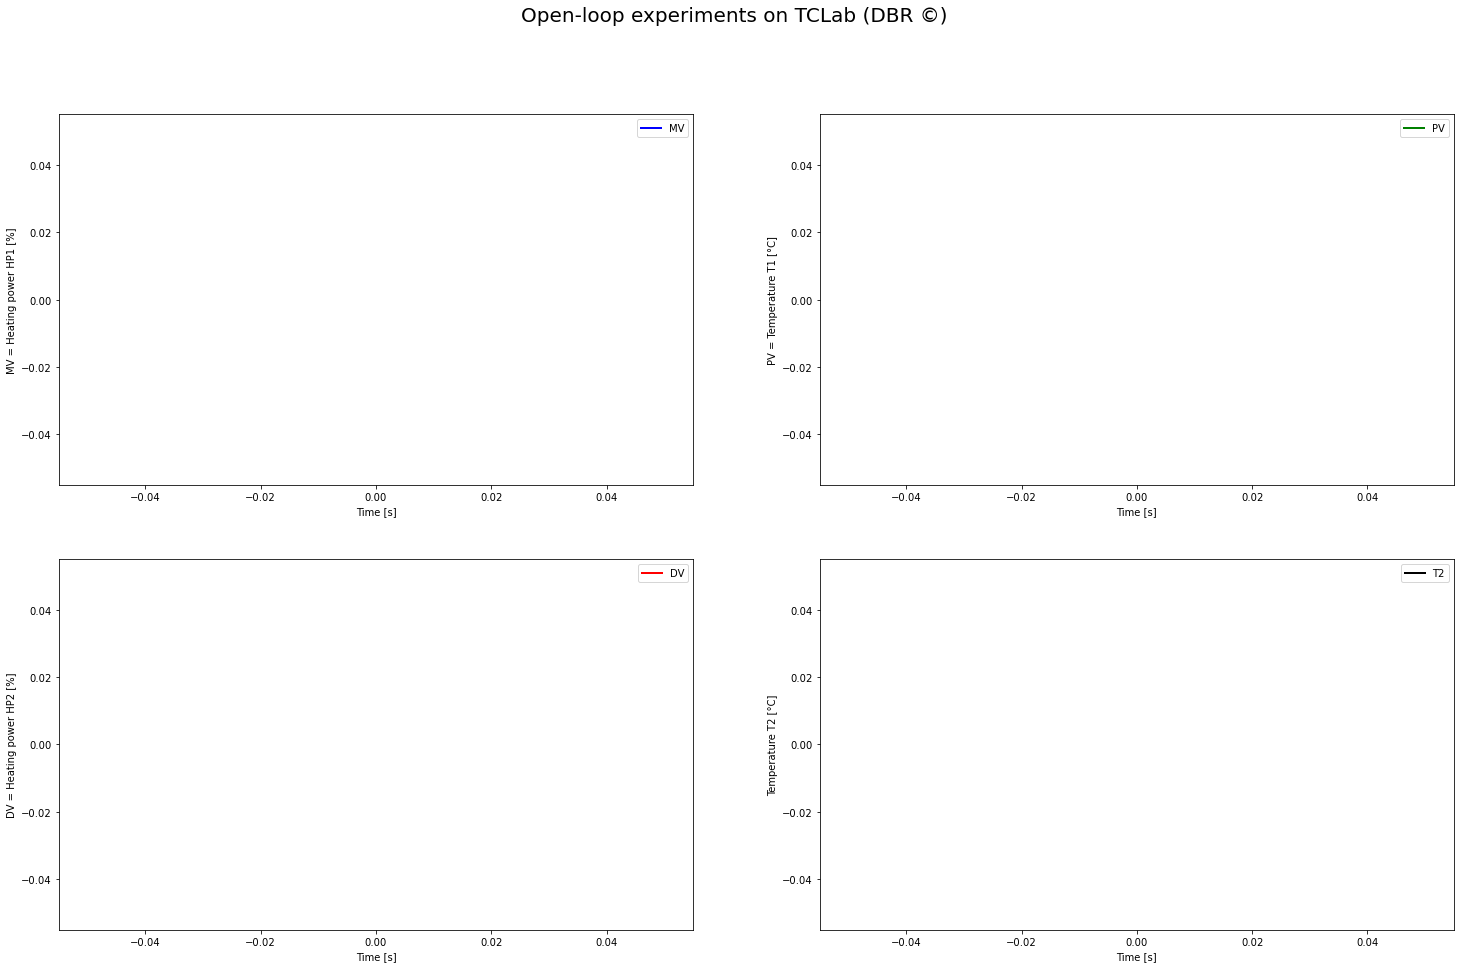

In [4]:
# Create a figure and axis for the plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.set_figheight(15)
fig.set_figwidth(25)
fig.suptitle('Open-loop experiments on TCLab (DBR ©)', fontsize = 20)

l1, = ax1.step([], [],'b-',linewidth = 2,label = 'MV',where = 'post')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('MV = Heating power HP1 [%]')
ax1.legend(loc='best')

l2, = ax2.step([], [],'g-',linewidth = 2,label = 'PV',where = 'post')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('PV = Temperature T1 [°C]')
ax2.legend(loc='best')

l3, = ax3.step([], [],'r-',linewidth = 2,label = 'DV',where = 'post')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('DV = Heating power HP2 [%]')
ax3.legend(loc='best')

l4, = ax4.step([], [],'k-',linewidth = 2,label = 'T2',where = 'post')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Temperature T2 [°C]')
ax4.legend(loc='best')

# Main program

In [5]:
# Create list to store data for the plot
t = []
MV = []
DV = []
PV = []
T2 = []

# Initialise connection and vectors
lab = tclab.TCLab()

if ExpVariable == 'MV':
    MVValue = MV0 - Delta
    DVValue = DV0
    lab.Q1(MVValue)
    lab.Q1(DVValue)
else: 
    MVValue = MV0
    DVValue = DV0 - Delta
    lab.Q1(MVValue)
    lab.Q1(DVValue)

t.append(0)
T1Value = lab.T1
T2Value = lab.T2    
MV.append(MVValue)
DV.append(DVValue)
PV.append(T1Value)    
T2.append(T2Value)

# To stop thread
stop_event = threading.Event()

# Start thread
thread = threading.Thread(target = update_data)
thread.start()

# Create a tkinter window
root = tk.Tk()
root.title('TCLab Real-Time plot: open-loop experiments')
root.config(bg = "white")
root.geometry('2200x1500')

frame = tk.Frame(width=100, height=100, bg = "white", colormap="new")
frame.grid(row = 1, column = 0)
frame.rowconfigure((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), minsize=10, weight = 1)
frame.columnconfigure((0, 1, 2), minsize=10, weight = 1)

# create Q1 label and entry
label_Q1 = tk.Label(frame, bg = "white", text='MV = Q1 [%]: ')
label_Q1.grid(row = 0, column = 1, sticky = W)
label_Q1.configure(font = 14)

entry_Q1 = tk.Entry(frame, width = 5, bd = 2, bg = 'lightblue')
entry_Q1.insert(-1, str(MVValue))
entry_Q1.grid(row = 0, column = 2, sticky = W)
entry_Q1.configure(font = 14)
entry_Q1.bind('<Return>', lambda event: update_Q1(entry_Q1.get()))

# create Q2 label and entry
label_Q2 = tk.Label(frame, bg = "white", text='DV = Q2 [%]: ')
label_Q2.grid(row = 2, column = 1, sticky = W)
label_Q2.configure(font = 14)

entry_Q2 = tk.Entry(frame, width = 5, bd = 2, bg = 'lightblue')
entry_Q2.insert(-1, str(DVValue))
entry_Q2.grid(row = 2, column = 2, sticky = W)
entry_Q2.configure(font = 14)
entry_Q2.bind('<Return>', lambda event: update_Q2(entry_Q2.get()))

# create a temperature display for T1
label_temp1 = tk.Label(frame, bg = "white", text='Temperature 1: -.- °C')
label_temp1.grid(row = 4, column = 1, columnspan = 2, sticky = W)
label_temp1.configure(font = 14)

# create a temperature display for T2
label_temp2 = tk.Label(frame, bg = "white", text='Temperature 2: -.- °C')
label_temp2.grid(row = 6, column = 1, columnspan = 2, sticky = W)
label_temp2.configure(font = 14)

# create button to set experiment
exp_button = tk.Button(frame, text = 'MV Experiment', command = exp_update, fg='black', bg='lightgray')
exp_button.grid(row = 8, column = 1, columnspan = 2, sticky = W)
exp_button.configure(font = 14)

# create button to reset plot
reset_button = tk.Button(frame, text = "Reset plot", command = reset_update, fg='black', bg='lightgray')
reset_button.grid(row = 10, column = 1, columnspan = 2, sticky = W)
reset_button.configure(font = 14)

# create button to stop plot & save
stop_button = tk.Button(frame, text = "Stop & Save", command = stop_update, fg='black', bg='lightgray')
stop_button.grid(row = 12, column = 1, columnspan = 2, sticky = W)
stop_button.configure(font = 14)

# Create a canvas for the plot
canvas = FigureCanvasTkAgg(fig, master = root)
canvas.get_tk_widget().grid(row = 1, column = 1)

# Schedule the first update
root.after(0, update_plot)

# Run the GUI
root.mainloop()

thread.join()

# Close the tclab connection
try:
    lab.close()
except:
    print('TClab already disconnected')

TCLab version 0.4.9
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware 1.4.3 Arduino Leonardo/Micro.
TCLab disconnected successfully.
TClab already disconnected
